In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [2]:
def sin_trajectory(t):
    return math.sin(t)

In [3]:
def plot_trajectory(trajectory, estimated_trajectory, 
                    generator_function, estimation_function,
                    title):
    plt.figure(figsize=(8, 4))
    plt.plot(trajectory[:, 0].numpy(), trajectory[:, 1].numpy(), label=f'{generator_function}(t)')
    plt.plot(estimated_trajectory[:, 0].numpy(), estimated_trajectory[:, 1].numpy(), label=f'{estimation_function}(t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
PERIOD = 4
times = torch.linspace(0, PERIOD * 2 * math.pi, steps=(PERIOD * 100))
values = torch.tensor([sin_trajectory(t.item()) for t in times])
trajectory = torch.stack([times, values], dim=1)

In [5]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim + 1] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)
	
	def forward(self, t, x):
		state = torch.cat([t.unsqueeze(0), x], dim=0)
		x_dot = self.mlp(state)
		return x_dot

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
ode = ODE(2, (256 for _ in range(3))).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 245.23043823242188
Epoch 2, Loss: 204.14683532714844
Epoch 3, Loss: 169.8053741455078
Epoch 4, Loss: 141.57847595214844
Epoch 5, Loss: 118.69345092773438
Epoch 6, Loss: 98.77346801757812
Epoch 7, Loss: 80.9302749633789
Epoch 8, Loss: 65.3820571899414
Epoch 9, Loss: 51.935218811035156
Epoch 10, Loss: 40.007484436035156
Epoch 11, Loss: 29.538408279418945
Epoch 12, Loss: 20.85871124267578
Epoch 13, Loss: 14.300031661987305
Epoch 14, Loss: 10.42570686340332
Epoch 15, Loss: 9.758989334106445
Epoch 16, Loss: 11.674135208129883
Epoch 17, Loss: 14.105700492858887
Epoch 18, Loss: 15.359752655029297
Epoch 19, Loss: 15.057413101196289
Epoch 20, Loss: 13.65069580078125
Epoch 21, Loss: 11.807507514953613
Epoch 22, Loss: 10.082319259643555
Epoch 23, Loss: 8.746293067932129
Epoch 24, Loss: 7.846189498901367
Epoch 25, Loss: 7.307886600494385
Epoch 26, Loss: 7.01740837097168
Epoch 27, Loss: 6.86639404296875
Epoch 28, Loss: 6.777252674102783
Epoch 29, Loss: 6.709920406341553
Epoch 30, Los

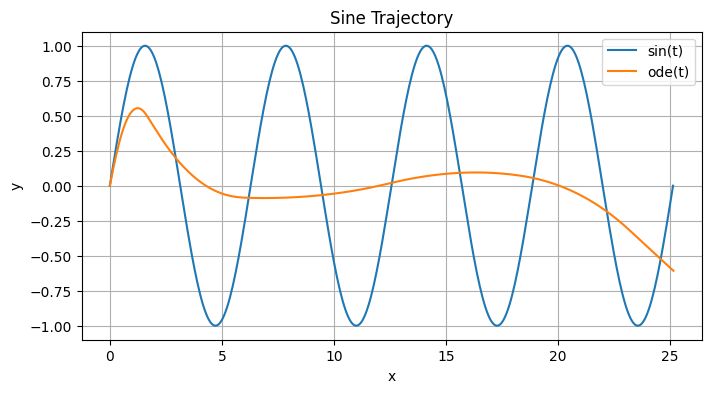

In [8]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')

In [9]:
class FourierFeatureODE(nn.Module):
    def __init__(self, input_dim, hidden_dims, fourier_scale=10.0, num_fourier_features=10, random_features=False):
        super(FourierFeatureODE, self).__init__()
        
        self.input_dim = input_dim
        self.num_fourier_features = num_fourier_features
        
        self.random_features = random_features
        self.register_buffer('B', torch.randn(input_dim, num_fourier_features) * fourier_scale)
        
        fourier_expanded_dim = input_dim + 2 * num_fourier_features
        dim_list = [fourier_expanded_dim + 1] + list(hidden_dims) + [input_dim]
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i < len(dim_list) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
    
    def compute_positional_fourier_features(self, x):
        encodings = [x]
        for i in range(self.num_fourier_features // 2):
            freq = 2.0 ** i
            sin_features = torch.sin(freq * x)
            cos_features = torch.cos(freq * x)
            encodings.append(sin_features)
            encodings.append(cos_features)
        return torch.cat(encodings, dim=-1)

    def forward(self, t, x):
        x_fourier = self.compute_positional_fourier_features(x)
        state = torch.cat([t.unsqueeze(0), x_fourier], dim=0)
        x_dot = self.mlp(state)
        return x_dot

In [ ]:
ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=4).to(device)
ode.train()

optim = torch.optim.Adam(ode.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

trajectory = trajectory.to(device)
initial_value = trajectory[0]
times = times.to(device)

EPOCHS = 10000
for epoch in range(EPOCHS):
    estimated_trajectory = odeint(ode, initial_value, times, method='euler')

    loss = F.mse_loss(trajectory, estimated_trajectory)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 119.8319320678711
Epoch 2, Loss: 109.42906951904297
Epoch 3, Loss: 101.17924499511719
Epoch 4, Loss: 93.81697082519531
Epoch 5, Loss: 86.02509307861328
Epoch 6, Loss: 78.92778778076172
Epoch 7, Loss: 71.9476547241211
Epoch 8, Loss: 65.19923400878906
Epoch 9, Loss: 58.78683090209961
Epoch 10, Loss: 52.62494659423828
Epoch 11, Loss: 46.83056640625
Epoch 12, Loss: 41.41251754760742
Epoch 13, Loss: 36.3165283203125
Epoch 14, Loss: 31.56431007385254
Epoch 15, Loss: 27.188392639160156
Epoch 16, Loss: 23.191234588623047
Epoch 17, Loss: 19.552291870117188
Epoch 18, Loss: 16.267221450805664
Epoch 19, Loss: 13.345645904541016
Epoch 20, Loss: 10.835119247436523
Epoch 21, Loss: 8.788678169250488
Epoch 22, Loss: 7.260810375213623
Epoch 23, Loss: 6.300382614135742
Epoch 24, Loss: 5.929057598114014
Epoch 25, Loss: 6.102076053619385
Epoch 26, Loss: 6.66903018951416
Epoch 27, Loss: 7.387292385101318
Epoch 28, Loss: 8.013002395629883
Epoch 29, Loss: 8.378267288208008
Epoch 30, Loss: 8.422

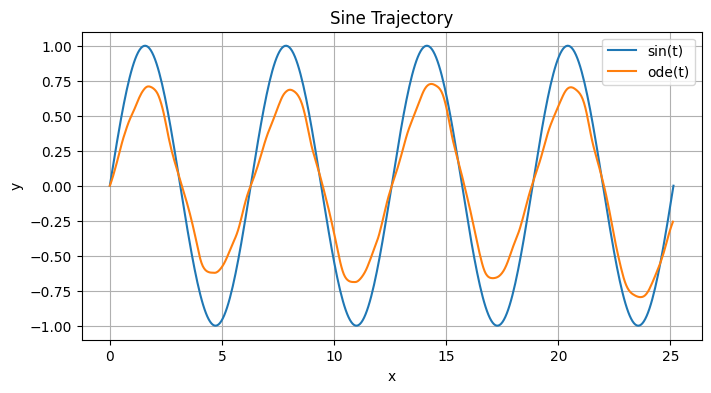

In [ ]:
estimated_trajectory = odeint(ode, initial_value, times, method='euler')
plot_trajectory(trajectory.cpu(), estimated_trajectory.detach().cpu(), 'sin', 'ode', 'Sine Trajectory')